In [1]:
import pandas as pd

# 读取数据
file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'
data = pd.read_csv(file_path)

/tmp/ipykernel_77599/2455671735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')


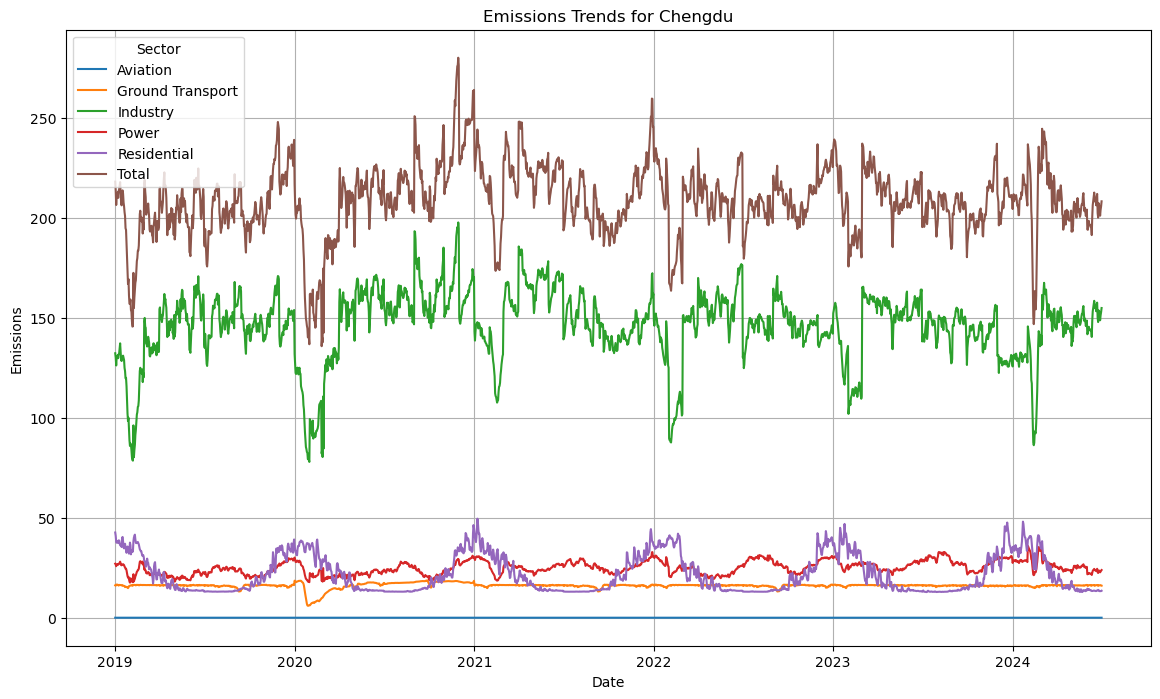

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter data for Melbourne
city_name = "Chengdu"
city_data = data[data['city'] == city_name]

# Convert date to datetime format for better plotting
city_data['date'] = pd.to_datetime(city_data['date'], format='%d/%m/%Y')

# Calculate the total emissions for all sectors
total_data = city_data.groupby('date')['value'].sum().reset_index()
total_data['sector'] = 'Total'

# Append the total data to the city data
city_data = pd.concat([city_data, total_data])

# Plotting the trends for each sector
plt.figure(figsize=(14, 8))

for sector in city_data['sector'].unique():
    sector_data = city_data[city_data['sector'] == sector]
    plt.plot(sector_data['date'], sector_data['value'], label=sector)

plt.title(f'Emissions Trends for {city_name}')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend(title='Sector')
plt.grid(True)
plt.show()

In [ ]:
total_data

In [3]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import ExpSineSquared

X = np.array(total_data['date'].index).reshape(-1, 1)
y = total_data['value']

In [ ]:
X

In [ ]:
y

In [4]:
# 定义核函数，常数核乘以RBF核
kernel = ExpSineSquared(length_scale=1.0, periodicity=1.0)

# 初始化GPR模型
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# 拟合模型
gp.fit(X, y)


/home/aster/miniconda3/envs/BayesOPt/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=1),
                         n_restarts_optimizer=10, normalize_y=True)

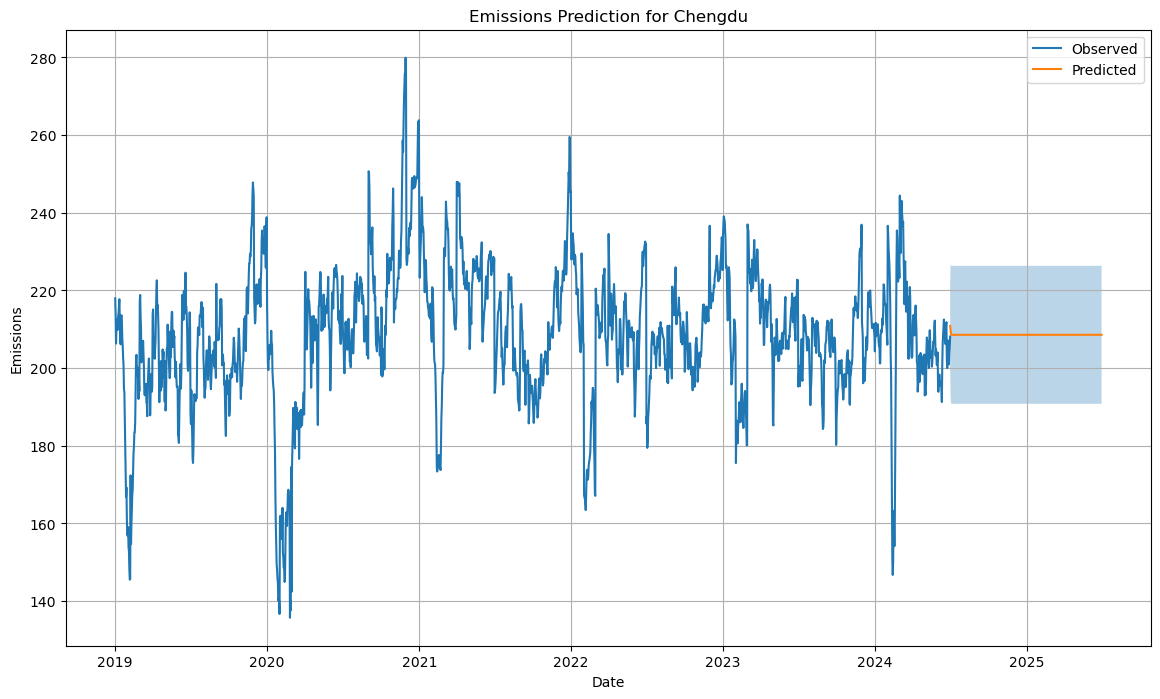

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设 gp 是已经训练好的高斯过程模型，total_data 包含历史数据

# 生成未来365天的日期
X_future = np.arange(X.max() + 1, X.max() + 366).reshape(-1, 1)

# 预测未来365天的数据
y_pred, sigma = gp.predict(X_future, return_std=True)

# 生成未来365天的日期范围
future_dates = pd.date_range(start=total_data['date'].max(), periods=365, freq='D')

# 绘制预测结果
plt.figure(figsize=(14, 8))
plt.plot(total_data['date'], total_data['value'], label='Observed')
plt.plot(future_dates, y_pred, label='Predicted')
plt.fill_between(future_dates, y_pred - sigma, y_pred + sigma, alpha=0.3)
plt.title(f'Emissions Prediction for {city_name}')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# 假设 total_data 包含历史数据
# total_data = pd.read_csv('your_data.csv')  # 示例数据加载

# 提取日期特征
total_data['dayofyear'] = total_data['date'].dt.dayofyear
total_data['year'] = total_data['date'].dt.year

# 准备训练数据
X = total_data[['dayofyear', 'year']].values
y = total_data['value'].values

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# 定义高斯过程模型
kernel = C(1.0, (1e-4, 1e1)) * RBF(10, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 训练模型
gp.fit(X_scaled, y_scaled)

# 生成未来365天的日期
future_dates = pd.date_range(start=total_data['date'].max(), periods=365, freq='D')
future_dayofyear = future_dates.dayofyear
future_year = future_dates.year
X_future = np.column_stack([future_dayofyear, future_year])

# 标准化未来数据
X_future_scaled = scaler_X.transform(X_future)

# 预测未来365天的数据
y_pred_scaled, sigma = gp.predict(X_future_scaled, return_std=True)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 绘制预测结果
plt.figure(figsize=(14, 8))
plt.plot(total_data['date'], total_data['value'], label='Observed')
plt.plot(future_dates, y_pred, label='Predicted')
plt.fill_between(future_dates, y_pred - sigma, y_pred + sigma, alpha=0.3)
plt.title(f'Emissions Prediction for {city_name}')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.legend()
plt.grid(True)
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[-2.45144698e-002  1.02394281e-001  4.79192805e-002  6.83557685e-003
  3.73816244e-004  8.37319342e-006  7.87357695e-008  3.13926557e-010
  5.32924723e-013  3.85877864e-016  1.19262848e-019  1.57387565e-023
  8.86961452e-028  2.13468314e-032  2.19415462e-037  9.63187356e-043
  1.80578492e-048  1.44588522e-054  4.94441047e-061  7.22118172e-068
  4.50417393e-075  1.19987273e-082  1.36511228e-090  6.63307234e-099
  1.37649381e-107  1.21996386e-116  4.61777571e-126  7.46503550e-136
  5.15399617e-146  1.51974064e-156  1.91385060e-167  1.02934216e-178
  2.36442020e-190  2.31954463e-202  9.71838220e-215  1.73899522e-227
  1.32897244e-240  4.33757234e-254  6.04631346e-268  3.59954625e-282
  9.15204251e-297  9.93805672e-312  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'  # 请替换为你的文件路径
df = pd.read_csv(file_path)

# 将'date'列转换为datetime格式
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['']
# 过滤墨尔本的数据
melbourne_total = df[df['city'] == 'Melbourne'].groupby(['city', 'date']).sum().reset_index()

# 确保'value'列为数值类型，并移除可能的NaN值
melbourne_total['value'] = pd.to_numeric(melbourne_total['value'], errors='coerce')
melbourne_total = melbourne_total.dropna(subset=['value'])

# 按日期排序
melbourne_total = melbourne_total.sort_values('date')

# 将数据集分为训练集（80%）和测试集（20%）
train_size = int(len(melbourne_total) * 0.8)
train_total = melbourne_total.iloc[:train_size]
test_total = melbourne_total.iloc[train_size:]

# 使用SARIMAX模型进行训练
model_total = SARIMAX(train_total['value'], order=(4, 1, 5), seasonal_order=(1, 1, 1, 6))
result_total = model_total.fit()

# 进行预测
forecast_total = result_total.get_forecast(steps=len(test_total))
forecast_total_values = forecast_total.predicted_mean
forecast_total_ci = forecast_total.conf_int()

# 绘制预测结果
plt.figure(figsize=(14, 7))
plt.plot(train_total['date'], train_total['value'], label='Train')
plt.plot(test_total['date'], test_total['value'], label='Test')
plt.plot(test_total['date'], forecast_total_values, label='Forecast')
plt.fill_between(test_total['date'], forecast_total_ci.iloc[:, 0], forecast_total_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Total Carbon Emissions')
plt.title('Melbourne Total Carbon Emissions Forecast')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# 读取用户上传的数据文件
file_path = 'data/carbonmonitor-cities_datas_2024-09-01.csv'
data = pd.read_csv(file_path)

# 查看数据的前几行
data.head()


In [ ]:
# 过滤出与墨尔本相关的数据，并选择日期和浓度值
melbourne_data = data[(data['city'] == 'Melbourne') & (data['sector'] == 'Aviation')]

# 转换日期格式为 datetime 格式
melbourne_data['date'] = pd.to_datetime(melbourne_data['date'], format='%d/%m/%Y')

# 按日期排序
melbourne_data = melbourne_data.sort_values(by='date')

# 查看处理后的数据
melbourne_data.head()


In [ ]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel
from sklearn.model_selection import train_test_split

# 假设你的数据已经处理完毕
# 将日期转换为时间戳并标准化
melbourne_data['timestamp'] = (melbourne_data['date'].astype(int) / 10**9).astype(float)
timestamps = melbourne_data['timestamp'].values
values = melbourne_data['value'].values

# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(timestamps, values, test_size=0.2, random_state=42)

# 将数据转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 定义高斯过程模型
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(
            RBFKernel() + PeriodicKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 使用最小二乘法来拟合
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(X_train, y_train, likelihood)

# 将模型设置为训练模式并优化
model.train()
likelihood.train()

optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

# 设置为评估模式
model.eval()
likelihood.eval()

# 进行预测
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(X_test))

# 打印预测结果
print(preds.mean[:5], y_test[:5])


In [ ]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
from gpytorch.kernels import RBFKernel, PeriodicKernel, ScaleKernel
from sklearn.model_selection import train_test_split

# 转换时间戳为年份并标准化
melbourne_data['year'] = melbourne_data['date'].dt.year
years = melbourne_data['year'].values.astype(float)
values = melbourne_data['value'].values

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(years, values, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 定义高斯过程模型
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(
            RBFKernel() + PeriodicKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 使用高斯似然性
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(X_train, y_train, likelihood)

# 训练模型
model.train()
likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

# 模型评估
model.eval()
likelihood.eval()

# 预测未来一年的数据
years_future = np.arange(X_test.min(), X_test.max() + 2, 1)
X_future = torch.tensor(years_future, dtype=torch.float32).unsqueeze(-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(X_future))

# 可视化结果
fig, ax = plt.subplots(figsize=(14, 6))

# 真实数据
ax.plot(X_test.numpy(), y_test.numpy(), 'k*', label='True Data')

# 预测均值
ax.plot(years_future, preds.mean.numpy(), 'b', label='Predicted Mean')

# 置信区间
lower, upper = preds.confidence_region()
ax.fill_between(years_future, lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')

# 设置坐标轴和标题
ax.set_xlabel('Year')
ax.set_ylabel('CO2 Concentration (scaled)')
ax.set_title('Predicted vs True CO2 Concentration with Uncertainty')
ax.set_ylim([values.min() * 0.9, values.max() * 1.1])  # 适当缩放y轴
ax.legend()

plt.show()


In [ ]:
# 确保数据按年份排序
sorted_indices = np.argsort(X_test.numpy().squeeze())
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]

# 确保预测年份的顺序
years_future_sorted = np.sort(years_future)

# 进行预测并可视化
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(torch.tensor(years_future_sorted, dtype=torch.float32).unsqueeze(-1)))

# 绘制图表
fig, ax = plt.subplots(figsize=(14, 6))

# 绘制真实数据
ax.plot(X_test_sorted.numpy(), y_test_sorted.numpy(), 'k*', label='True Data')

# 绘制预测均值
ax.plot(years_future_sorted, preds.mean.numpy(), 'b', label='Predicted Mean')

# 绘制置信区间
lower, upper = preds.confidence_region()
ax.fill_between(years_future_sorted, lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')

# 设置坐标轴和标题
ax.set_xlabel('Year')
ax.set_ylabel('CO2 Concentration (scaled)')
ax.set_title('Predicted vs True CO2 Concentration with Uncertainty')
ax.set_ylim([values.min() * 0.9, values.max() * 1.1])  # 适当缩放y轴
ax.legend()

plt.show()
